In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, RepeatVector
import pandas as pd
import csv
from datetime import datetime

In [2]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

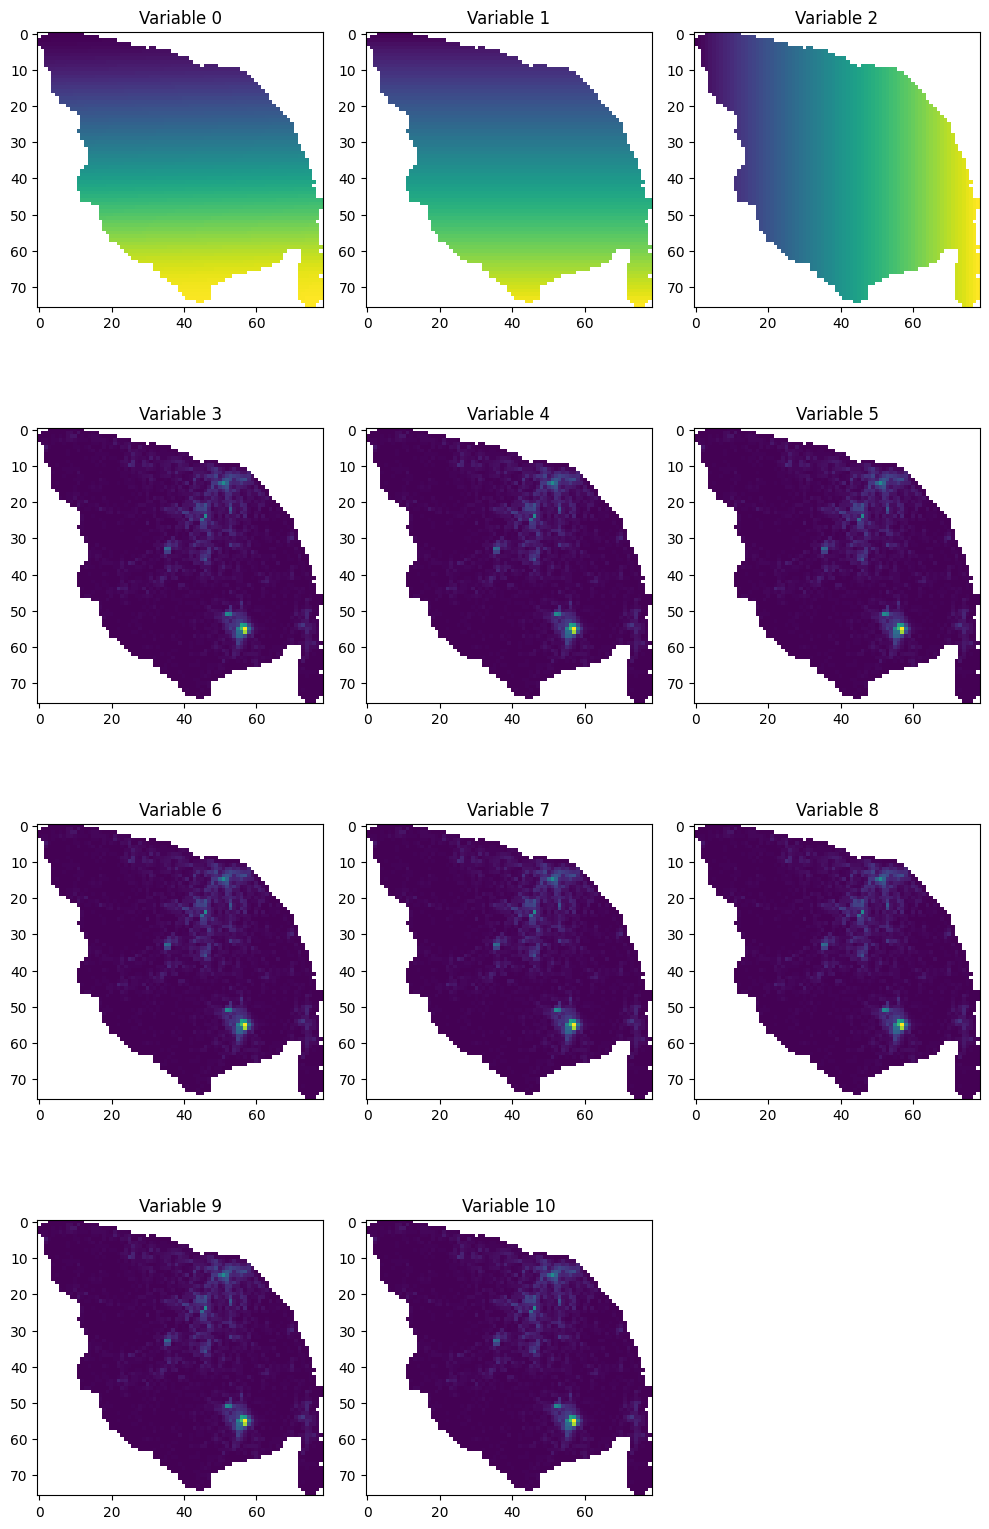

In [3]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

Model definition and train

In [4]:
# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape, forecast_range):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100))
    model.add(RepeatVector(forecast_range))
    model.add(LSTM(units=100, return_sequences= True))
    model.add(TimeDistributed(Dense(output_shape)))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

In [5]:
N_IN_24_H = 24*4
FORECAST_RANGE = 4 # 1 hour

In [6]:
def windowed_dataset(data, relevant_cells_mask, window_size, batch_size, shift, forecast_range):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (window[:-forecast_range], tf.stack([window[-i,:,:,0][relevant_cells_mask] for i in range(forecast_range)])))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [7]:
def ingestion(data, window_size, shift, batch_size, forecast_range):
    cell_ids = data[...,0,0]
    relevant_cells_mask = ~np.isnan(cell_ids)
    output_shape = relevant_cells_mask.sum()

    # Setting the timestep dim as the first dimensions
    data = np.transpose(data, (2, 0, 1, 3))
    print(f'Whole dataset shape: {data.shape}')

    # Using only the C's data
    x_data = data[...,3:]
    x_data[np.isnan(x_data)] = 0
    # Train/val split
    x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
    x_data_val = x_data[int(x_data.shape[0]*2/3):int(x_data.shape[0]*(2/3 + 1/6)),...]
    x_data_test = x_data[int(x_data.shape[0]*(2/3 + 1/6)):,...]

    train_dataset = windowed_dataset(x_data_train, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    validation_dataset = windowed_dataset(x_data_val, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    test_dataset = windowed_dataset(x_data_test, relevant_cells_mask, window_size, batch_size, shift, forecast_range)

    return train_dataset, validation_dataset, test_dataset, output_shape

In [8]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that. - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

def train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis):

    model = CNN_LSTM(input_shape, output_shape, forecast_range)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    # the patience parameter is the number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_scheduler])

    # summarize history for loss
    if vis:
        # list all data in history
        print(history.history.keys())

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    return model, history.history['loss'], history.history['val_loss']

# Run experiment

In [9]:
def experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=5e-3, epochs=100, vis=False, model_path='model.h5', forecast_range=4):
    # Ingestion
    train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift, batch_size, forecast_range)
    input_shape = (None,96,76,79,8)

    # Train
    model, train_loss, val_loss = train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis)
    model.save(model_path)

    ## We don't need this anymore, the fit method will take care of that for us
    # # Model prediction
    # relevant_cells_mask = ~np.isnan(data[...,0,0])
    # ground_truth = x_data_val_and_test[N_IN_24_H,...,0][relevant_cells_mask]
    # pred, mse = predict_evaluate(model, x_data_val_and_test, ground_truth)

    return model, train_loss, val_loss, test_dataset

To run single experiment:
`model, train_loss, val_loss = experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=1e-2, vis=True, model_path='model.h5')`

## Iterate over multiple window_sizes

In [10]:
header = ['timestamp', 'window', 'forecast_range', 'train_loss', 'val_loss']

Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 20:46:58.453848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-19 20:46:58.459506: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-19 20:47:01.393441: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2237906944 exceeds 10% of free system memory.
2023-04-19 20:47:03.781664: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 559092480 exceeds 10% of free 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 96, 76, 79, 4)    132       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 96, 38, 39, 2)    34        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 96, 19, 19, 2)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 96, 19, 19, 1)    9

2023-04-19 20:47:05.758326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 20:47:05.759949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 20:47:05.760997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 repeat_vector (RepeatVector  (None, 4, 100)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 100)            80400     
                                                                 
 time_distributed_7 (TimeDis  (None, 4, 3743)          378043    
 tributed)                                                       
                                                                 
Total params: 531,418
Trainable params: 531,418
Non-trainable params: 0
_________________________________________________________________


2023-04-19 20:47:06.055991: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2237906944 exceeds 10% of free system memory.
2023-04-19 20:47:06.667699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 20:47:06.667992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]


Epoch 1/60


2023-04-19 20:47:07.191500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 20:47:07.192984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 20:47:07.193969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

      8/Unknown - 27s 2s/step - loss: 585.1339

2023-04-19 20:47:43.304263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 20:47:43.308068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 20:47:45.440795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 41s 4s/step - loss: 585.1339 - val_loss: 248.0699 - lr: 0.0030
Epoch 2/60
8/8 [==============================] - 19s 2s/step - loss: 557.1697 - val_loss: 226.0163 - lr: 0.0030
Epoch 3/60
8/8 [==============================] - 16s 2s/step - loss: 528.1706 - val_loss: 208.7702 - lr: 0.0030
Epoch 4/60
8/8 [==============================] - 15s 2s/step - loss: 504.5013 - val_loss: 194.9594 - lr: 0.0030
Epoch 5/60
8/8 [==============================] - 14s 2s/step - loss: 484.6186 - val_loss: 183.5918 - lr: 0.0030
Epoch 6/60
8/8 [==============================] - 14s 2s/step - loss: 467.5012 - val_loss: 174.0616 - lr: 0.0030
Epoch 7/60
8/8 [==============================] - 15s 2s/step - loss: 452.5840 - val_loss: 165.9389 - lr: 0.0030
Epoch 8/60
8/8 [==============================] - 14s 2s/step - loss: 439.4143 - val_loss: 158.9335 - lr: 0.0030
Epoch 9/60
8/8 [==============================] - 14s 2s/step - loss: 427.6491 - val_loss: 152.8284 - lr: 0

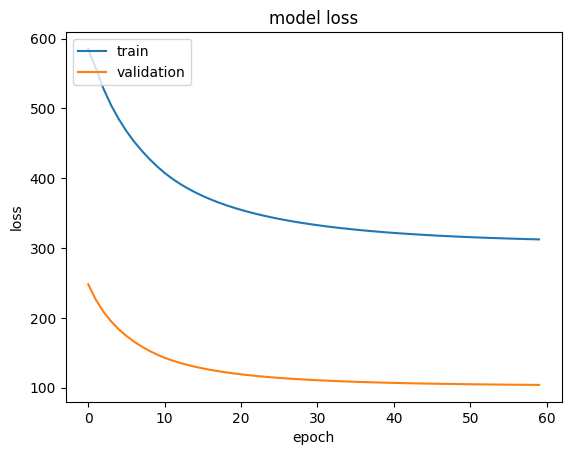

FINISH:  ['2023-04-19 21:02:09', 96, 4, [585.1338500976562, 557.169677734375, 528.1705932617188, 504.50128173828125, 484.6185607910156, 467.5011901855469, 452.5839538574219, 439.4143371582031, 427.6491394042969, 417.0325012207031, 407.5738220214844, 399.3040771484375, 392.0072021484375, 385.5181884765625, 379.7091369628906, 374.4793395996094, 369.7480773925781, 365.4499206542969, 361.5307312011719, 357.9456787109375, 354.6566162109375, 351.6314392089844, 348.84234619140625, 346.26556396484375, 343.8802185058594, 341.6681823730469, 339.6134033203125, 337.70196533203125, 335.92138671875, 334.2604675292969, 332.7093811035156, 331.2591552734375, 329.90185546875, 328.63031005859375, 327.43804931640625, 326.3190612792969, 325.2680358886719, 324.2801208496094, 323.3508605957031, 322.4761962890625, 321.6523132324219, 320.8759765625, 320.1438903808594, 319.4532165527344, 318.80126953125, 318.1856384277344, 317.60400390625, 317.0542297363281, 316.5344543457031, 316.04278564453125, 315.5775756835

2023-04-19 21:03:24.638651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:03:24.647534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:03:24.648558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 96, 76, 79, 4)    132       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 96, 19, 19, 1)    9         
 stributed

2023-04-19 21:03:25.675667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:03:25.675961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]


Epoch 1/60


2023-04-19 21:03:26.682550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:03:26.683986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:03:26.684886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

      8/Unknown - 24s 2s/step - loss: 593.0601

2023-04-19 21:03:53.774235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:03:53.774721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:03:54.830481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 45s 5s/step - loss: 593.0601 - val_loss: 245.2277 - lr: 0.0030
Epoch 2/60
8/8 [==============================] - 17s 2s/step - loss: 561.4072 - val_loss: 223.8735 - lr: 0.0030
Epoch 3/60
8/8 [==============================] - 15s 2s/step - loss: 532.8702 - val_loss: 207.4721 - lr: 0.0030
Epoch 4/60
8/8 [==============================] - 15s 2s/step - loss: 509.1624 - val_loss: 193.9183 - lr: 0.0030
Epoch 5/60
8/8 [==============================] - 14s 2s/step - loss: 488.7515 - val_loss: 182.5916 - lr: 0.0030
Epoch 6/60
8/8 [==============================] - 15s 2s/step - loss: 471.0241 - val_loss: 173.0402 - lr: 0.0030
Epoch 7/60
8/8 [==============================] - 15s 2s/step - loss: 455.4760 - val_loss: 164.8750 - lr: 0.0030
Epoch 8/60
8/8 [==============================] - 15s 2s/step - loss: 441.6807 - val_loss: 157.8137 - lr: 0.0030
Epoch 9/60
8/8 [==============================] - 15s 2s/step - loss: 429.3078 - val_loss: 151.6455 - lr: 0

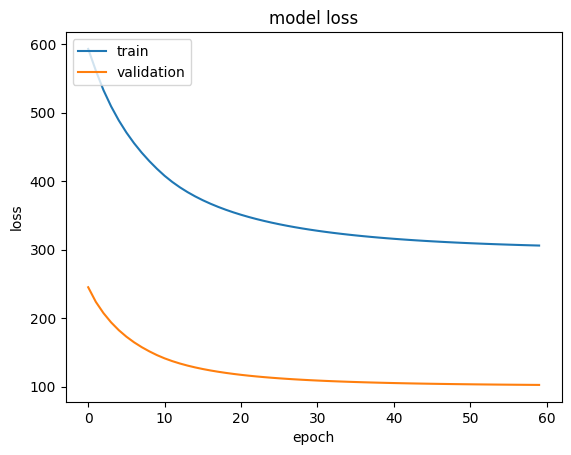

FINISH:  ['2023-04-19 21:19:16', 96, 48, [593.0601196289062, 561.4072265625, 532.8701782226562, 509.162353515625, 488.7514953613281, 471.02410888671875, 455.47601318359375, 441.68072509765625, 429.30780029296875, 418.0673522949219, 407.84515380859375, 398.9143981933594, 391.0426025390625, 384.05499267578125, 377.8114318847656, 372.2000427246094, 367.1309814453125, 362.5315856933594, 358.34228515625, 354.5135803222656, 351.0039367675781, 347.77813720703125, 344.80609130859375, 342.0618591308594, 339.52288818359375, 337.1696472167969, 334.9847412109375, 332.953125, 331.061279296875, 329.2972717285156, 327.65045166015625, 326.1112365722656, 324.67108154296875, 323.3222351074219, 322.05780029296875, 320.8713684082031, 319.7572326660156, 318.710205078125, 317.7254943847656, 316.798828125, 315.9261169433594, 315.10382080078125, 314.3284912109375, 313.59716796875, 312.90692138671875, 312.255126953125, 311.63946533203125, 311.0575256347656, 310.5073547363281, 309.9869689941406, 309.49465942382

2023-04-19 21:21:23.477900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:21:23.503415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:21:23.552481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 21:21:24.459176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:21:24.463209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:21:24.467745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/60


2023-04-19 21:21:27.150414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:21:27.154486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:21:27.158701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     15/Unknown - 43s 2s/step - loss: 580.4218

2023-04-19 21:22:12.235361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:22:12.235766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:22:13.099856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

15/15 [==============================] - 50s 2s/step - loss: 580.4218 - val_loss: 232.1834 - lr: 0.0030
Epoch 2/60
15/15 [==============================] - 29s 2s/step - loss: 527.8549 - val_loss: 202.1264 - lr: 0.0030
Epoch 3/60
15/15 [==============================] - 28s 2s/step - loss: 488.4612 - val_loss: 181.5148 - lr: 0.0030
Epoch 4/60
15/15 [==============================] - 28s 2s/step - loss: 458.5489 - val_loss: 166.3079 - lr: 0.0030
Epoch 5/60
15/15 [==============================] - 28s 2s/step - loss: 434.7222 - val_loss: 154.6588 - lr: 0.0030
Epoch 6/60
15/15 [==============================] - 27s 2s/step - loss: 415.0248 - val_loss: 145.4279 - lr: 0.0030
Epoch 7/60
15/15 [==============================] - 27s 2s/step - loss: 398.2944 - val_loss: 137.8992 - lr: 0.0030
Epoch 8/60
15/15 [==============================] - 27s 2s/step - loss: 383.7974 - val_loss: 131.6475 - lr: 0.0030
Epoch 9/60
15/15 [==============================] - 27s 2s/step - loss: 371.0582 - val_loss

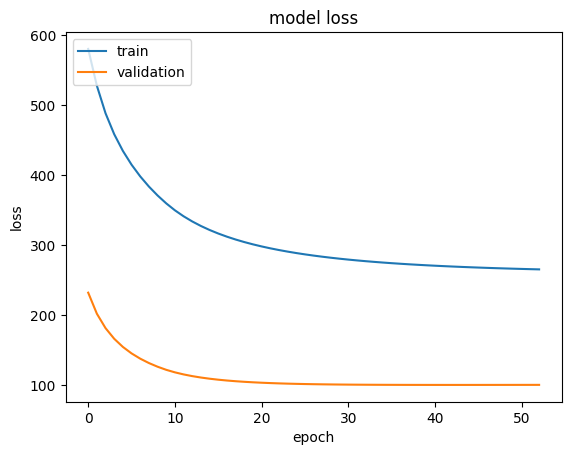

FINISH:  ['2023-04-19 21:46:34', 192, 4, [580.4218139648438, 527.8548583984375, 488.46124267578125, 458.5488586425781, 434.72222900390625, 415.0248107910156, 398.29437255859375, 383.79736328125, 371.0582275390625, 359.7479248046875, 349.8435974121094, 341.3249816894531, 333.9276123046875, 327.4519348144531, 321.743896484375, 316.6823425292969, 312.17059326171875, 308.1302185058594, 304.4968566894531, 301.21728515625, 298.246826171875, 295.5479431152344, 293.0889587402344, 290.84185791015625, 288.7840270996094, 286.89501953125, 285.1572265625, 283.5555114746094, 282.07635498046875, 280.7081604003906, 279.4403076171875, 278.2638244628906, 277.17059326171875, 276.1532287597656, 275.205322265625, 274.3211364746094, 273.495361328125, 272.723388671875, 272.0010681152344, 271.3244323730469, 270.69012451171875, 270.09490966796875, 269.5359802246094, 269.0107421875, 268.51678466796875, 268.0519714355469, 267.6142578125, 267.20184326171875, 266.8131103515625, 266.4464111328125, 266.1003112792969

2023-04-19 21:48:17.369221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:48:17.460218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:48:17.461129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 21:48:18.007069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:48:18.009662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:48:18.013853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/60


2023-04-19 21:48:22.272462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 21:48:22.274161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 21:48:22.275254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     14/Unknown - 68s 2s/step - loss: 584.9066

2023-04-19 21:49:30.412115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:49:30.412476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 21:49:32.529981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

14/14 [==============================] - 75s 2s/step - loss: 584.9066 - val_loss: 224.3818 - lr: 0.0030
Epoch 2/60
14/14 [==============================] - 31s 2s/step - loss: 533.9695 - val_loss: 196.7065 - lr: 0.0030
Epoch 3/60
14/14 [==============================] - 31s 2s/step - loss: 495.3005 - val_loss: 177.0105 - lr: 0.0030
Epoch 4/60
14/14 [==============================] - 29s 2s/step - loss: 465.1039 - val_loss: 162.2552 - lr: 0.0030
Epoch 5/60
14/14 [==============================] - 30s 2s/step - loss: 440.7197 - val_loss: 150.8795 - lr: 0.0030
Epoch 6/60
14/14 [==============================] - 30s 2s/step - loss: 420.3962 - val_loss: 141.8862 - lr: 0.0030
Epoch 7/60
14/14 [==============================] - 29s 2s/step - loss: 403.0539 - val_loss: 134.5825 - lr: 0.0030
Epoch 8/60
14/14 [==============================] - 29s 2s/step - loss: 387.9792 - val_loss: 128.5422 - lr: 0.0030
Epoch 9/60
14/14 [==============================] - 29s 2s/step - loss: 374.6993 - val_loss

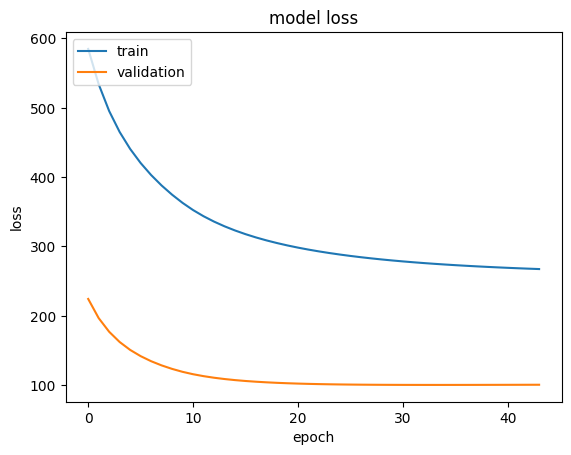

FINISH:  ['2023-04-19 22:10:26', 192, 48, [584.9066162109375, 533.9695434570312, 495.300537109375, 465.1039123535156, 440.71966552734375, 420.39617919921875, 403.0539245605469, 387.9792175292969, 374.6993103027344, 362.88458251953125, 352.5481262207031, 343.6419982910156, 335.896484375, 329.1071472167969, 323.1156921386719, 317.7975158691406, 313.05267333984375, 308.8000793457031, 304.97320556640625, 301.5166320800781, 298.384033203125, 295.53631591796875, 292.940185546875, 290.5672912597656, 288.3931579589844, 286.39666748046875, 284.5594482421875, 282.865478515625, 281.30072021484375, 279.8529052734375, 278.5110778808594, 277.2657165527344, 276.10809326171875, 275.0307312011719, 274.0267639160156, 273.0900573730469, 272.2151794433594, 271.3971862792969, 270.6315612792969, 269.91436767578125, 269.2419128417969, 268.61090087890625, 268.0182800292969, 267.4613342285156], [224.3818359375, 196.7064971923828, 177.01048278808594, 162.2551727294922, 150.8794708251953, 141.88624572753906, 134

2023-04-19 22:12:30.999317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:12:31.063681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:12:31.065481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 22:12:31.535515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:12:31.537753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:12:31.539193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/60


2023-04-19 22:12:36.049602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:12:36.051254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:12:36.052147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     14/Unknown - 54s 2s/step - loss: 589.6771

2023-04-19 22:13:30.841417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 22:13:30.841773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 22:13:33.280369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

14/14 [==============================] - 61s 2s/step - loss: 589.6771 - val_loss: 223.6175 - lr: 0.0030
Epoch 2/60
14/14 [==============================] - 29s 2s/step - loss: 538.4271 - val_loss: 195.7144 - lr: 0.0030
Epoch 3/60
14/14 [==============================] - 29s 2s/step - loss: 498.8952 - val_loss: 175.7921 - lr: 0.0030
Epoch 4/60
14/14 [==============================] - 29s 2s/step - loss: 468.0574 - val_loss: 160.9727 - lr: 0.0030
Epoch 5/60
14/14 [==============================] - 29s 2s/step - loss: 443.2362 - val_loss: 149.5987 - lr: 0.0030
Epoch 6/60
14/14 [==============================] - 29s 2s/step - loss: 422.6004 - val_loss: 140.6430 - lr: 0.0030
Epoch 7/60
14/14 [==============================] - 29s 2s/step - loss: 405.0222 - val_loss: 133.3953 - lr: 0.0030
Epoch 8/60
14/14 [==============================] - 29s 2s/step - loss: 389.7606 - val_loss: 127.4189 - lr: 0.0030
Epoch 9/60
14/14 [==============================] - 29s 2s/step - loss: 376.3274 - val_loss

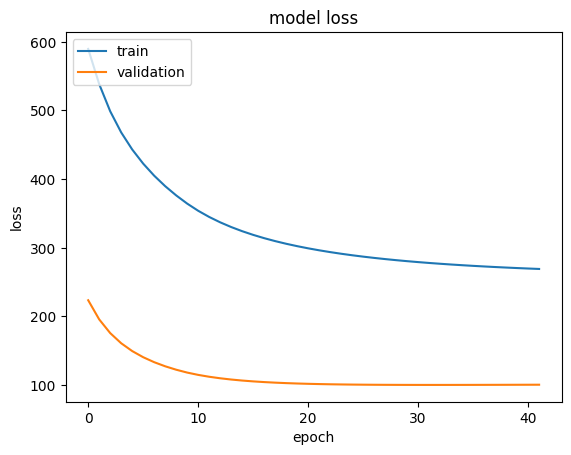

FINISH:  ['2023-04-19 22:33:39', 192, 96, [589.6771240234375, 538.4270629882812, 498.8951721191406, 468.0574035644531, 443.2361755371094, 422.60040283203125, 405.022216796875, 389.7605895996094, 376.327392578125, 364.38348388671875, 353.9355163574219, 344.9363708496094, 337.1119689941406, 330.2549133300781, 324.2044677734375, 318.83447265625, 314.0437316894531, 309.75042724609375, 305.8869934082031, 302.3976135253906, 299.2354431152344, 296.3609313964844, 293.74053955078125, 291.34552001953125, 289.15118408203125, 287.1361999511719, 285.2820129394531, 283.5724182128906, 281.9932556152344, 280.5321350097656, 279.17803955078125, 277.9212341308594, 276.7530212402344, 275.66583251953125, 274.65264892578125, 273.7074279785156, 272.82452392578125, 271.9990539550781, 271.2264709472656, 270.5027770996094, 269.8241882324219, 269.1873779296875], [223.61752319335938, 195.71444702148438, 175.79209899902344, 160.97267150878906, 149.5986785888672, 140.6429901123047, 133.395263671875, 127.41893768310

2023-04-19 22:35:59.150825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:35:59.260531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:35:59.262319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 22:35:59.836470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:35:59.839100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:35:59.842276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/60


2023-04-19 22:36:02.521118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:36:02.525167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:36:02.526092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     28/Unknown - 65s 2s/step - loss: 570.2059

2023-04-19 22:37:10.520276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 22:37:10.520655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 22:37:12.260507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

28/28 [==============================] - 75s 2s/step - loss: 570.2059 - val_loss: 196.9404 - lr: 0.0030
Epoch 2/60
28/28 [==============================] - 53s 2s/step - loss: 491.9306 - val_loss: 163.1126 - lr: 0.0030
Epoch 3/60
28/28 [==============================] - 52s 2s/step - loss: 442.1216 - val_loss: 143.2670 - lr: 0.0030
Epoch 4/60
28/28 [==============================] - 52s 2s/step - loss: 407.0041 - val_loss: 130.3086 - lr: 0.0030
Epoch 5/60
28/28 [==============================] - 52s 2s/step - loss: 380.1652 - val_loss: 121.2641 - lr: 0.0030
Epoch 6/60
28/28 [==============================] - 52s 2s/step - loss: 358.7183 - val_loss: 114.8050 - lr: 0.0030
Epoch 7/60
28/28 [==============================] - 53s 2s/step - loss: 341.1349 - val_loss: 110.1995 - lr: 0.0030
Epoch 8/60
28/28 [==============================] - 52s 2s/step - loss: 326.4511 - val_loss: 106.9768 - lr: 0.0030
Epoch 9/60
28/28 [==============================] - 52s 2s/step - loss: 314.0654 - val_loss

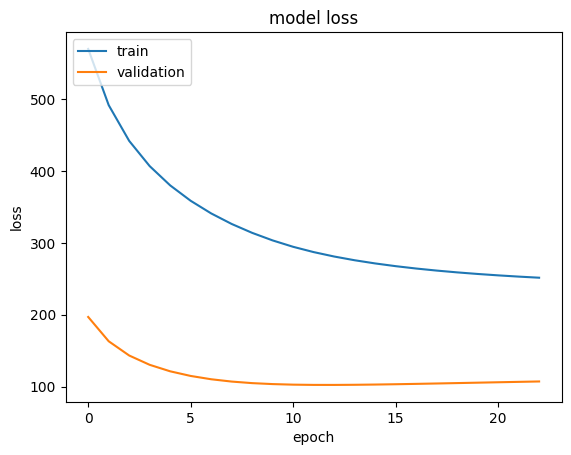

FINISH:  ['2023-04-19 22:56:30', 384, 4, [570.2059326171875, 491.9305725097656, 442.12158203125, 407.0040588378906, 380.1651611328125, 358.71826171875, 341.13494873046875, 326.4510803222656, 314.06536865234375, 303.524658203125, 294.63726806640625, 287.2766418457031, 281.1220397949219, 275.9241027832031, 271.4951477050781, 267.6917419433594, 264.4027099609375, 261.540283203125, 259.0348205566406, 256.8303527832031, 254.88128662109375, 253.15032958984375, 251.60687255859375], [196.94044494628906, 163.11256408691406, 143.2670440673828, 130.30857849121094, 121.26406860351562, 114.80503845214844, 110.19945526123047, 106.97679901123047, 104.8147964477539, 103.47262573242188, 102.68450164794922, 102.34152221679688, 102.31053924560547, 102.49658203125, 102.83175659179688, 103.26737213134766, 103.7684097290039, 104.30945587158203, 104.87218475341797, 105.44336700439453, 106.01348876953125, 106.5757827758789, 107.12553405761719]]
Whole dataset shape: (8736, 76, 79, 11)
Model: "sequential_6"


2023-04-19 22:59:06.934983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:59:07.004451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:59:07.005718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 96, 19, 19, 1)    9         
 stributed

2023-04-19 22:59:08.612029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 22:59:08.612377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]


Epoch 1/60


2023-04-19 22:59:10.579187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 22:59:10.580437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 22:59:10.581667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     27/Unknown - 59s 2s/step - loss: 569.7784

2023-04-19 23:00:10.269682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:00:10.270246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:00:12.286786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

27/27 [==============================] - 68s 2s/step - loss: 569.7784 - val_loss: 184.0459 - lr: 0.0030
Epoch 2/60
27/27 [==============================] - 60s 2s/step - loss: 494.8836 - val_loss: 152.4738 - lr: 0.0030
Epoch 3/60
27/27 [==============================] - 54s 2s/step - loss: 445.8227 - val_loss: 133.8357 - lr: 0.0030
Epoch 4/60
27/27 [==============================] - 61s 2s/step - loss: 410.6710 - val_loss: 121.7315 - lr: 0.0030
Epoch 5/60
27/27 [==============================] - 57s 2s/step - loss: 383.5829 - val_loss: 113.3676 - lr: 0.0030
Epoch 6/60
27/27 [==============================] - 54s 2s/step - loss: 361.8361 - val_loss: 107.4886 - lr: 0.0030
Epoch 7/60
27/27 [==============================] - 55s 2s/step - loss: 343.9492 - val_loss: 103.3914 - lr: 0.0030
Epoch 8/60
27/27 [==============================] - 55s 2s/step - loss: 329.0020 - val_loss: 100.6281 - lr: 0.0030
Epoch 9/60
27/27 [==============================] - 55s 2s/step - loss: 316.3728 - val_loss

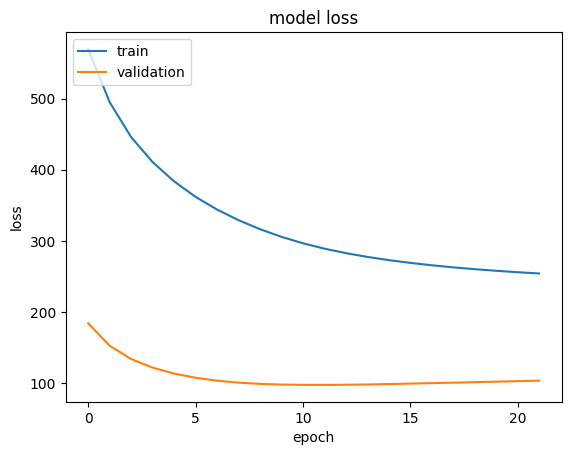

FINISH:  ['2023-04-19 23:19:16', 384, 48, [569.7784423828125, 494.8835754394531, 445.82269287109375, 410.6710205078125, 383.58294677734375, 361.83612060546875, 343.9492492675781, 329.001953125, 316.3727722167969, 305.6144714355469, 296.53863525390625, 289.0161437988281, 282.723876953125, 277.4080810546875, 272.87786865234375, 268.9870910644531, 265.6222229003906, 262.6938781738281, 260.1308288574219, 257.8757629394531, 255.88221740722656, 254.1119384765625], [184.0459442138672, 152.47377014160156, 133.835693359375, 121.73149108886719, 113.36759185791016, 107.48861694335938, 103.39139556884766, 100.62814331054688, 98.88362884521484, 97.92411041259766, 97.46768951416016, 97.41806030273438, 97.64894104003906, 98.06996154785156, 98.61685943603516, 99.24383544921875, 99.91825103759766, 100.61692810058594, 101.32347106933594, 102.02628326416016, 102.71720123291016, 103.3905029296875]]
Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 23:22:09.483012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 23:22:09.484139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 23:22:09.485010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_56 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_60 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 23:22:10.975201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:22:10.975518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]


Epoch 1/60


2023-04-19 23:22:13.679616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 23:22:13.681113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 23:22:13.682112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

     27/Unknown - 79s 3s/step - loss: 574.5406

2023-04-19 23:23:35.151230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:23:35.151758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:23:39.064248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

27/27 [==============================] - 95s 3s/step - loss: 574.5406 - val_loss: 182.2767 - lr: 0.0030
Epoch 2/60
27/27 [==============================] - 61s 2s/step - loss: 498.0618 - val_loss: 150.9050 - lr: 0.0030
Epoch 3/60
27/27 [==============================] - 66s 2s/step - loss: 448.4675 - val_loss: 132.3622 - lr: 0.0030
Epoch 4/60
27/27 [==============================] - 59s 2s/step - loss: 412.9245 - val_loss: 120.3491 - lr: 0.0030
Epoch 5/60
27/27 [==============================] - 56s 2s/step - loss: 385.5534 - val_loss: 112.0666 - lr: 0.0030
Epoch 6/60
27/27 [==============================] - 56s 2s/step - loss: 363.5874 - val_loss: 106.2566 - lr: 0.0030
Epoch 7/60
27/27 [==============================] - 58s 2s/step - loss: 345.5225 - val_loss: 102.2185 - lr: 0.0030
Epoch 8/60
27/27 [==============================] - 56s 2s/step - loss: 330.4271 - val_loss: 99.5061 - lr: 0.0030
Epoch 9/60
27/27 [==============================] - 56s 2s/step - loss: 317.6724 - val_loss:

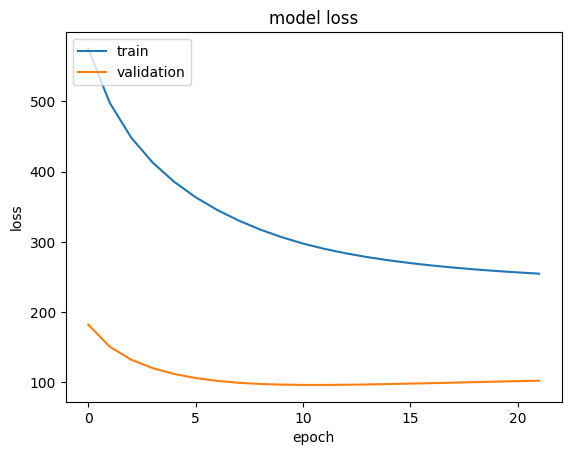

FINISH:  ['2023-04-19 23:43:53', 384, 96, [574.5406494140625, 498.0617980957031, 448.46746826171875, 412.9245300292969, 385.5533752441406, 363.5873718261719, 345.52252197265625, 330.42706298828125, 317.67236328125, 306.8064270019531, 297.6357727050781, 290.0348815917969, 283.6767272949219, 278.30487060546875, 273.7265625, 269.7940979003906, 266.392822265625, 263.4324645996094, 260.841064453125, 258.560791015625, 256.5447692871094, 254.75430297851562], [182.27667236328125, 150.90496826171875, 132.36221313476562, 120.3491439819336, 112.06657409667969, 106.256591796875, 102.21851348876953, 99.50608825683594, 97.80543518066406, 96.88371276855469, 96.45541381835938, 96.42808532714844, 96.67672729492188, 97.1119155883789, 97.67017364501953, 98.30635070800781, 98.98827362060547, 99.69300842285156, 100.40422821044922, 101.1104736328125, 101.80386352539062, 102.47898864746094]]


In [11]:
# fast

# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results_fast.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['24h_1h', '24h_12h', '48h_1h', '48h_12h', '48_24h', '96h_1h', '96h_12h', '96h_24h']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 16, 16, 16, 8, 8, 8, 8]
    FORECAST_RANGE_list = [4, 12*4, 4, 12*4, 24*4, 4, 12*4, 24*4]

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    # QUESTION: Should we also try with different forecast_ranges ??
    writer.writerow(header)
    for i, window in enumerate([N_IN_24_H, N_IN_24_H, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*4, N_IN_24_H*4, N_IN_24_H*4]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE_list[i], shift = 25, batch_size=batch_size_list[i], lr=3e-3, epochs=60, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE_list[i])
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, FORECAST_RANGE_list[i], train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

## Using a trained model to perform predictions

Here we can either train a new model, or simply import one already trained.

Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 23:46:26.941706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 23:46:27.027914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 23:46:27.029859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 96, 38, 39, 2)    34        
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 96, 19, 19, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 96, 19, 19, 1)   

2023-04-19 23:46:27.665840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 23:46:27.667334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 23:46:27.669963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3


2023-04-19 23:46:30.418896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 23:46:30.421800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 23:46:30.425970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

      8/Unknown - 49s 2s/step - loss: 607.2705

2023-04-19 23:47:19.620799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:47:19.621137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:47:20.685393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 53s 2s/step - loss: 607.2705 - val_loss: 243.2995 - lr: 0.0050
Epoch 2/3
8/8 [==============================] - 17s 2s/step - loss: 559.6146 - val_loss: 215.5847 - lr: 0.0050
Epoch 3/3
8/8 [==============================] - 16s 2s/step - loss: 521.1628 - val_loss: 195.1227 - lr: 0.0050
dict_keys(['loss', 'val_loss', 'lr'])


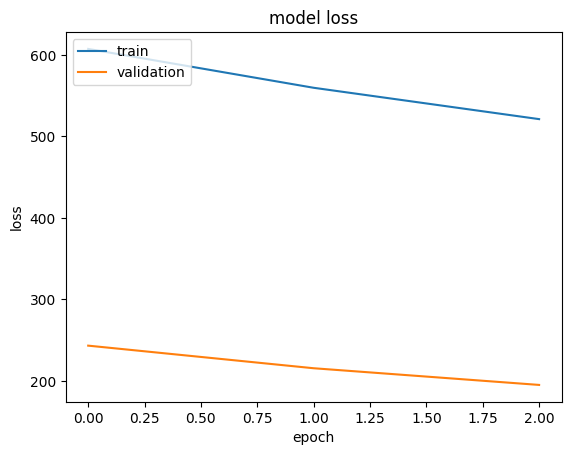

Whole dataset shape: (8736, 76, 79, 11)


In [14]:
# Training a new model
window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 24

model, train_loss, val_loss, test_dataset = experiment(data, window_size = window_size, shift = shift, batch_size=32, lr=5e-3, epochs=3, vis=True, model_path = f'models/model.h5', forecast_range= FORECAST_RANGE)
train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=1, forecast_range=FORECAST_RANGE)

In [15]:
# Loading a previously trained model
# Here it is important to ensure that the test_dataset is using the same window_size and forecast_range as you used to train your model

window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 4

train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=32, forecast_range=FORECAST_RANGE)
model = tf.keras.models.load_model('models/model.h5')

Whole dataset shape: (8736, 76, 79, 11)


2023-04-19 23:52:13.254152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 23:52:13.396203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 23:52:13.398912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Next we predict on the whole test dataset. We evaluate the MSE there and save all the predictions

In [16]:
def predict_evaluate(model, x_test, y_test):
    pred = model(x_test).numpy()
    mse = np.mean((y_test - pred)**2)
    return pred, mse

mse_list = []
pred_list = []
y_true_list = []

for x,y in test_dataset:
    pred, mse = predict_evaluate(model, x, y)
    mse_list.append(mse)
    pred_list.append(pred)
    y_true_list.append(y.numpy())
    
predictions = np.stack(pred_list[:-1])
ys = np.stack(y_true_list[:-1])

# Do not use the last mse value, it may be from a batch different than the batch size
# This happens if the total number of samples is not divisible by the batch size
MSE = np.mean(mse_list[:-1])
print(f'MSE for the test data: {MSE}')

2023-04-19 23:52:16.676727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1457,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-19 23:52:16.677034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1457,76,79,8]
	 [[{{node Placeholder/_0}}]]


MSE for the test data: 807.0118738145511


Next we plot some predictions and compare it to our ground truth.

In [17]:
# Function to convert the 1D prediction into a 2D image
def pred_into_grid(pred, ground_truth):

    grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
    dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

    # grid indexes
    grelha_x = dfs_grid['grelha_x'].values -1
    grelha_y = dfs_grid['grelha_y'].values -1
    grelha_id =  dfs_grid['grelha_id'].values 

    grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
    grelha_id_2d[:] = np.nan
    pred_2d = grelha_id_2d.copy()
    ground_truth_2d = grelha_id_2d.copy()

    # Indices to map from
    idx_2d = np.stack([grelha_y, grelha_x])

    # Assign the elements to the regular rectangular grid
    pred_2d[tuple(idx_2d)] = pred.ravel()
    ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()

    return pred_2d, ground_truth_2d

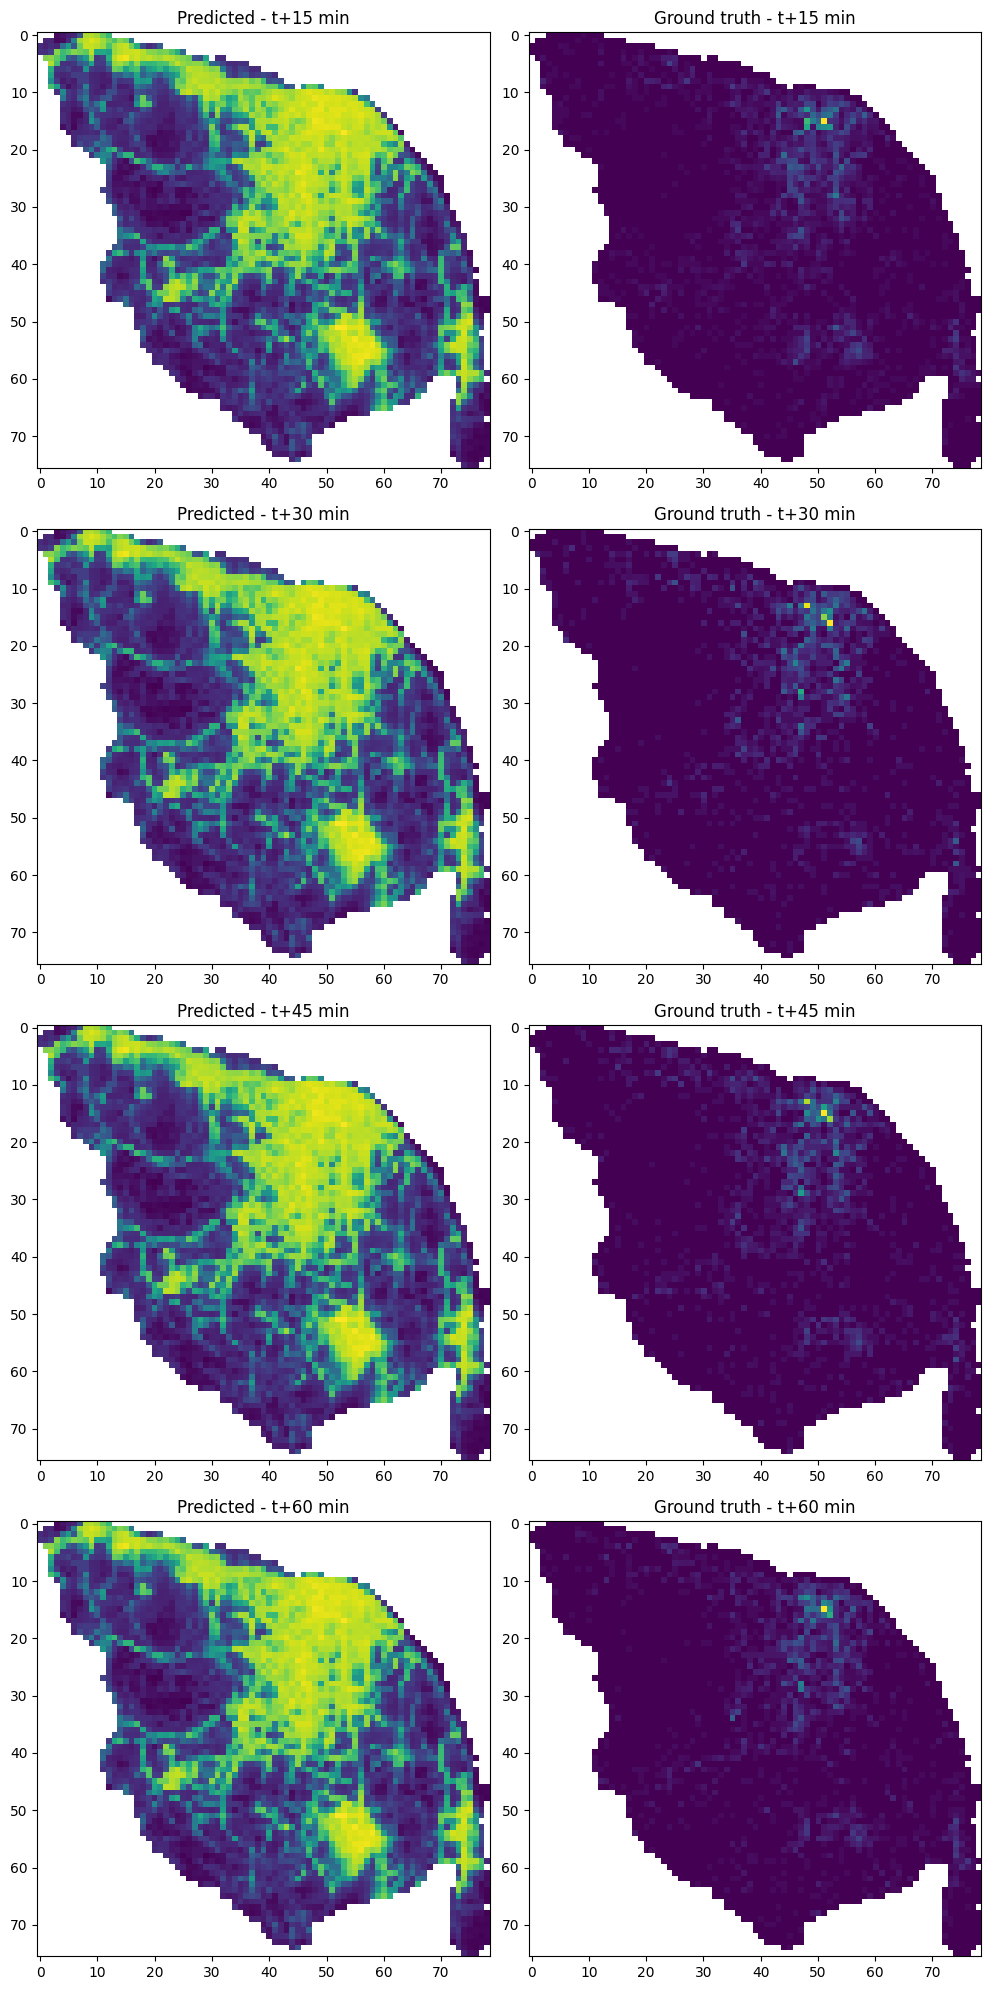

In [18]:
example_pred  = predictions[0,0]
example_truth = ys[0,0]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for time in range(4):
    # Define some pred and ground truth here 
    pred_2d, ground_truth_2d = pred_into_grid(example_pred[time], example_truth[time])

    axs[time,0].set_title(f'Predicted - t+{15*(time+1)} min')
    axs[time,0].imshow(pred_2d)

    axs[time,1].set_title(f'Ground truth - t+{15*(time+1)} min')
    axs[time,1].imshow(ground_truth_2d)
plt.tight_layout()
plt.show()

In [19]:
truth_stats = stats.describe(predictions.flatten())
pred_stats = stats.describe(ys.flatten())

print("RESULTS")
print("MSE:", MSE)
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)

RESULTS
MSE: 807.0118738145511
Ground Truth Stats: DescribeResult(nobs=4791040, minmax=(-0.14972183, 11.438719), mean=4.115102, variance=12.388175689029088, skewness=0.5816687875475826, kurtosis=-1.2019993077544802)
Predictions Stats:  DescribeResult(nobs=4791040, minmax=(0.0, 1107.0799560546875), mean=10.704583719830191, variance=841.7510284597387, skewness=9.053568265229877, kurtosis=140.18455767858933)


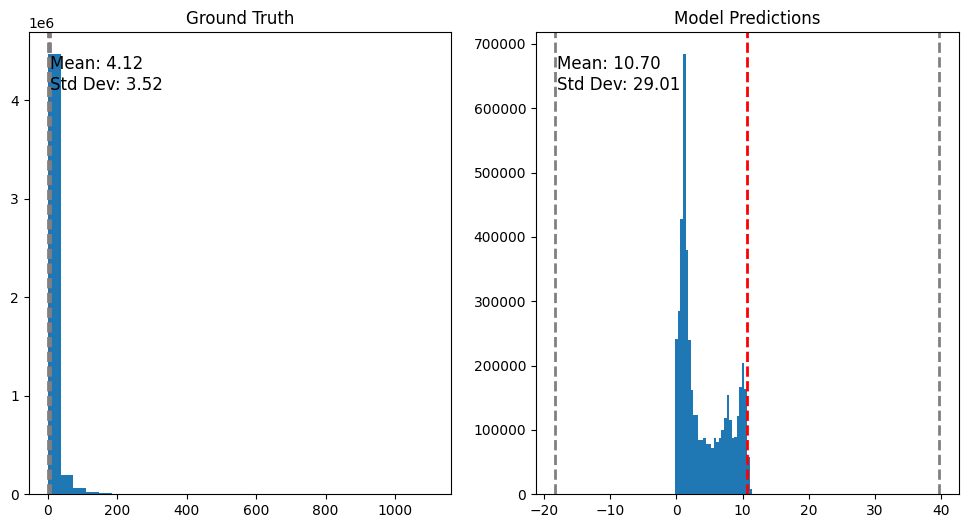

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ys.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(predictions.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()